## Importation des librairies

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Formation_OCR_Ing_Machine_Learning/Projet 7/Stage_Noémie

/content/drive/MyDrive/Formation_OCR_Ing_Machine_Learning/Projet 7/Stage_Noémie


In [18]:
from PIL import Image

In [2]:
torch.__version__

'1.11.0+cu113'

In [1]:
import pandas as pad 
import numpy as np
from numpy import argmax
from numpy import sqrt
from numpy.core.numeric import NaN
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as multi 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.cluster import adjusted_rand_score
from joblib import dump, load
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
import random
import pandas.util.testing as tm
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from XBNet.training_utils import training,predict
from XBNet.models import XBNETClassifier
from XBNet.run import run_XBNET
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG
from libauc.datasets import ImbalanceSampler

# Importation des données

In [ ]:
df = pad.read_excel('Database_finale.xlsx')
columns = ['SAS10', 'MCSv', 'LT',	'LTMCS',	'AAV',	'LSV', 'Gamma_moyen', 'Class_GM_5%']
df = df[columns]
df.dropna(axis = 0, how ='any')

In [9]:
df = pad.read_excel('Database_finale.xlsx')
df
# Importation des données
X = df.drop("Class", axis = 1)
y = df["Class"]

In [ ]:
df['Class_GM_5%'].value_counts()

1    1569
0      63
Name: Class_GM_5%, dtype: int64

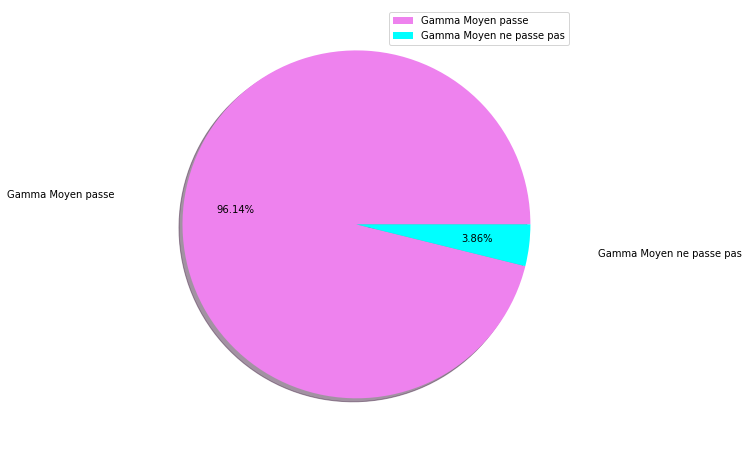

In [ ]:
plt.figure(figsize = (8, 8))
x = [1569, 63]
plt.pie(x, labels = ['Gamma Moyen passe', 'Gamma Moyen ne passe pas'],
           colors = ['Violet', 'Cyan'],
           explode = [0, 0],
           autopct = lambda x: str(round(x, 2)) + '%',
           pctdistance = 0.7, labeldistance = 1.4,
           shadow = True)
plt.legend()

Les données sont vraiment disproportionnées, il va falloir prendre cette information en compte pour la modélisation

In [ ]:
# Suppression des données non utiles 
list_to_drop = ['Gamma_moyen']
df2 = df.drop(list_to_drop, axis=1)

# Importation des données
X = df2.drop("Class_GM_5%", axis = 1)
y = df2["Class_GM_5%"]

# Méthode baseline - Machine Learning

In [10]:
X_np = np.array(X)

In [ ]:
sc = StandardScaler()

In [13]:
X_norm = sc.fit_transform(X_np)

In [ ]:
dump(sc, 'StandardScaler.joblib')

['StandardScaler_5%.joblib']

In [12]:
sc = load('StandardScaler.joblib')

In [14]:
X = X_norm

In [ ]:
# Répartition des données en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 7)

# Sur-échantillonnage des données d'entraînement
ros = RandomOverSampler(sampling_strategy='minority')
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

## Entrainement rapide sans optimisation des hyperparamètres

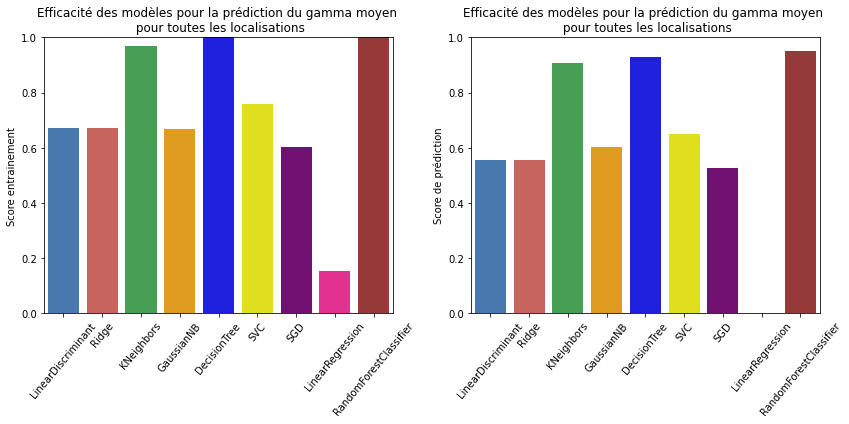

In [ ]:
# Création des modèles
List_of_models = [LinearDiscriminantAnalysis(), RidgeClassifier(), KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), SVC(), SGDClassifier(), LinearRegression(), RandomForestClassifier()]
List_of_models_for_graph = ["LinearDiscriminant", "Ridge", "KNeighbors", "GaussianNB", "DecisionTree", "SVC", "SGD", "LinearRegression", "RandomForestClassifier"]

def run_model_and_performance_check(model):

    # Choix du modèle et entraînement du modèle
    model_class = model
    model_class.fit(X_train_res, y_train_res)

    # Prédiction du modèle et archivage des résultats
    y_pred = model_class.predict(X_test)

    # Création des dataframes résultats
    results_classification = np.array([model_class.score(X_train_res,y_train_res), model_class.score(X_test,y_test)])
    df_results = pad.DataFrame(index = ["Score entrainement", "Score de prédiction"], columns = [str(model)[:-2]])
    df_results[str(model)[:-2]] = results_classification

    return df_results

df_results = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearDiscriminant"])

# Entrainement des modèles et évaluation de leurs performances sans optimisation préalable
for i in range(len(List_of_models)):
  model_class = List_of_models[i] 
  model_class.fit(X_train_res, y_train_res)
  y_pred = model_class.predict(X_test)
  results_classification = np.array([model_class.score(X_train_res,y_train_res), model_class.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results[List_of_models_for_graph[i]] = results_classification

custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

df_graph = df_results.transpose()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entrainement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph.index, y=df_graph["Score de prédiction"].values, data=df_graph, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=50)
ax1.set_title('Efficacité des modèles pour la prédiction du gamma moyen \n pour toutes les localisations')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=50)
ax2.set_title('Efficacité des modèles pour la prédiction du gamma moyen \n pour toutes les localisations')
ax2.set_ylabel('Score de prédiction')
ax2.set(ylim=(0, 1))

plt.tight_layout()
#fig.savefig("Performance modèles classification all data", dpi=400)

Sans optimisation les modèles KNeighbors, DecisionTree et RandomForestClassifier apparaissent comme étant les plus pertinents

## Optimisation des hyperparamètres

In [ ]:
# Modèle LinearDiscriminant 
LinearDiscriminant_parameters = {'solver' : ['svd', 'lsqr', 'eigen'], 
                                 'store_covariance' : [True, False],
                                 'tol' : [0.0001,0.0002,0.0003]}

LinearDiscriminant_GridSearchCV = GridSearchCV(estimator = LinearDiscriminantAnalysis(), param_grid = LinearDiscriminant_parameters, cv = 5, n_jobs=-1)
LinearDiscriminant_GridSearchCV.fit(X_train_res, y_train_res)
LinearDiscriminant_GridSearchCV.best_params_
print("LinearDiscriminant best param = " + str(LinearDiscriminant_GridSearchCV.best_params_))

# Modèle RidgeClassifier
RidgeClassifier_parameters = {'alpha' : list(range(1,20)),
                              'fit_intercept' : [True, False],
                              'copy_X' : [True, False],
                              'tol' : [0.0001,0.0002,0.0003],
                              'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

RidgeClassifier_GridSearchCV = GridSearchCV(estimator = RidgeClassifier(), param_grid = RidgeClassifier_parameters, cv = 5, n_jobs=-1)
RidgeClassifier_GridSearchCV.fit(X_train_res, y_train_res)
RidgeClassifier_GridSearchCV.best_params_
print("RidgeClassifier best param = " + str(RidgeClassifier_GridSearchCV.best_params_))

# Modèle KNeighbors
KNeighborsClassifier_parameters = {#'n_neighbors' : list(range(1,50)),
                                   #'leaf_size' : list(range(1,30)), 
                                   'p':[1,2], 
                                   'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
                                   'metric' : ['minkowski','euclidean','manhattan']}

KNeighborsClassifier_GridSearchCV = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = KNeighborsClassifier_parameters, cv = 5, n_jobs=-1)
KNeighborsClassifier_GridSearchCV.fit(X_train_res, y_train_res)
KNeighborsClassifier_GridSearchCV.best_params_
print("KNeighborsClassifier best param = " + str(KNeighborsClassifier_GridSearchCV.best_params_))

# Modèle GaussianNB
GaussianNB_parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
GaussianNB_GridSearchCV = GridSearchCV(estimator = GaussianNB(), param_grid = GaussianNB_parameters, cv = 5, n_jobs=-1)
GaussianNB_GridSearchCV.fit(X_train_res, y_train_res)
GaussianNB_GridSearchCV.best_params_

print("GaussianNB best param = " +str(GaussianNB_GridSearchCV.best_params_))

# Modèle DecisionTree
DecisionTreeClassifier_parameters = {#'max_features' : ['auto', 'sqrt', '“log2'],
                                     'max_depth': [2, 10, 15,18,20],
                                     'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100],
                                     "min_samples_split": [2, 6, 20],
                                     'criterion': ["gini", "entropy"],
                                     'splitter' : ['best', 'random'],
                                     'min_samples_split' : np.linspace(0.1, 1.0, 5, endpoint=True).tolist()}

DecisionTreeClassifier_GridSearchCV = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = DecisionTreeClassifier_parameters, cv = 5, n_jobs=-1, verbose = 2)
DecisionTreeClassifier_GridSearchCV.fit(X_train_res, y_train_res)
DecisionTreeClassifier_GridSearchCV.best_params_
print("DecisionTreeClassifier best param = " +str(DecisionTreeClassifier_GridSearchCV.best_params_))

# Modèle SVC
SVC_parameters = {#'C': [1, 10, 50, 100, 200, 300],
                  'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                  'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                  'probability': [True, False]}
                  
SVC_GridSearchCV = GridSearchCV(estimator = SVC(), param_grid = SVC_parameters, cv=5, n_jobs=-1, verbose=2)
SVC_GridSearchCV.fit(X_train_res, y_train_res)
SVC_GridSearchCV.best_params_
print("SVC best param = " +str(SVC_GridSearchCV.best_params_))

# Modèle SGD
SGD_parameters = {'loss' : ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                  'penalty' : ['l1', 'l2', 'elasticnet'], 
                  'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
                  'l1_ratio' : [0, 0.10, 0.15, 0.20, 0.30], 
                  'fit_intercept' : [True, False],
                  'tol' : [0.0001,0.0002,0.0003]}


SGD_GridSearchCV = GridSearchCV(estimator = SGDClassifier(), param_grid = SGD_parameters, cv=5, n_jobs=-1, verbose=2)
SGD_GridSearchCV.fit(X_train_res, y_train_res)
SGD_GridSearchCV.best_params_
print("SGD best param = " +str(SGD_GridSearchCV.best_params_))

# Modèle LinearRegression
LinearRegression_parameters = {'fit_intercept' : [True, False], 
                               'copy_X' : [True, False], 
                               'positive' : [True, False]}


LinearRegression_GridSearchCV = GridSearchCV(estimator = LinearRegression(), param_grid = LinearRegression_parameters, cv=5, n_jobs=-1, verbose=2)
LinearRegression_GridSearchCV.fit(X_train_res, y_train_res)
LinearRegression_GridSearchCV.best_params_
print("LinearRegression best param = " +str(LinearRegression_GridSearchCV.best_params_))

# Modèle RandomForestClassifier
RandomForestClassifier_parameters = {'criterion' : ['gini', 'entropy'],
                                     'n_estimators' : [1,10,20,30], 
                                     'min_samples_split' : [2,5,7,9,10], 
                                     'min_samples_leaf' : [1,2,5,7,8], 
                                     'max_features' : ['auto', 'sqrt', 'log2']}


RandomForestClassifier_GridSearchCV = GridSearchCV(estimator = RandomForestClassifier(), param_grid = RandomForestClassifier_parameters, cv=5, n_jobs=-1, verbose=2)
RandomForestClassifier_GridSearchCV.fit(X_train_res, y_train_res)
RandomForestClassifier_GridSearchCV.best_params_
coefficients = RandomForestClassifier_GridSearchCV.best_estimator_.feature_importances_
print("RandomForestClassifier best param = " +str(RandomForestClassifier_GridSearchCV.best_params_))

LinearDiscriminant best param = {'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}
RidgeClassifier best param = {'alpha': 3, 'copy_X': True, 'fit_intercept': True, 'solver': 'auto', 'tol': 0.0001}
KNeighborsClassifier best param = {'algorithm': 'auto', 'metric': 'minkowski', 'p': 1}
GaussianNB best param = {'var_smoothing': 0.533669923120631}
Fitting 5 folds for each of 700 candidates, totalling 3500 fits
DecisionTreeClassifier best param = {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'splitter': 'best'}
Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC best param = {'gamma': 1, 'kernel': 'rbf', 'probability': True}
Fitting 5 folds for each of 4050 candidates, totalling 20250 fits
SGD best param = {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.3, 'loss': 'log', 'penalty': 'l1', 'tol': 0.0002}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
LinearRegression best param = {'copy_X': True, 'fit_intercept'

In [ ]:
X

array([[-0.17103511, -0.09601301, -0.00218869, -0.10405621, -0.36800055,
         1.08539718],
       [-0.25065206, -0.37869776, -0.29587134, -0.27580025, -0.62473676,
         1.03533391],
       [ 0.04042064, -1.07288562,  1.49449621, -1.27894159, -1.05263044,
         0.35484431],
       ...,
       [-1.0468215 ,  1.08482202, -0.75036719,  1.20354048,  1.40470184,
        -1.28611835],
       [ 0.39998104, -1.47007559,  1.72029048, -1.62242968, -1.38271986,
         0.10081959],
       [ 1.4606842 , -1.46291901,  1.28875441, -1.53655766, -1.40228071,
         0.31034363]])

In [ ]:
X = pad.DataFrame(X, columns = ['SAS10', 'MCSv', 'LT',	'LTMCS',	'AAV',	'LSV'])
X

,SAS10,MCSv,LT,LTMCS,AAV,LSV
0,-0.171035,-0.096013,-0.002189,-0.104056,-0.368001,1.085397
1,-0.250652,-0.378698,-0.295871,-0.275800,-0.624737,1.035334
2,0.040421,-1.072886,1.494496,-1.278942,-1.052630,0.354844
3,-0.616205,0.054275,-0.448254,0.157463,-0.052582,0.275114
4,1.125951,-0.582660,-0.655905,-0.365576,-0.390007,-0.766944
...,...,...,...,...,...,...
1627,0.178252,-0.013712,0.419059,-0.158702,-0.069698,0.137903
1628,-0.224113,0.537344,0.059164,0.426789,0.822766,-1.093282
1629,-1.046821,1.084822,-0.750367,1.203540,1.404702,-1.286118
1630,0.399981,-1.470076,1.720290,-1.622430,-1.382720,0.100820


## Evaluation des features ayant le plus d'importance dans la modélisation

In [ ]:
np.array(coefficients)

array([0.14453121, 0.17407112, 0.20981266, 0.15361626, 0.17400629,
       0.14396246])

In [ ]:
liste_coef = pad.concat((pad.DataFrame(X.columns, columns = ['Variables']), pad.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

In [ ]:
liste_coef

,Variables,Coefficients
2,LT,0.209813
1,MCSv,0.174071
4,AAV,0.174006
3,LTMCS,0.153616
0,SAS10,0.144531
5,LSV,0.143962


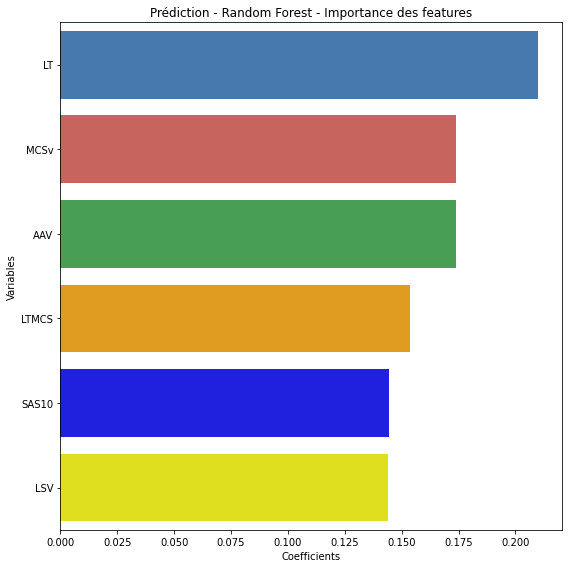

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Prédiction - Random Forest - Importance des features')
ax = sns.barplot(y = liste_coef['Variables'], x = liste_coef['Coefficients'])
plt.tight_layout()
fig = ax.get_figure()
fig.savefig("Importance des features dans le modèle", dpi=400)
plt.show()

Les features ont globalement tous la même importance pour la modélisation

## Visualisation des performances des modèles avec optimisation des hyperparamètres

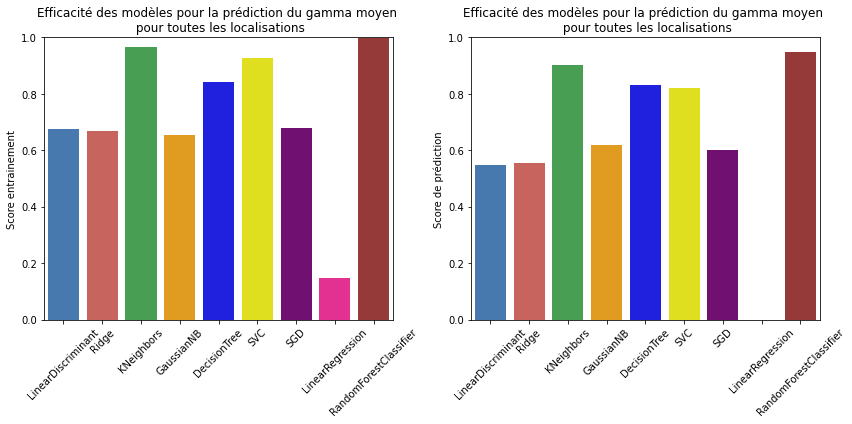

In [ ]:
List_of_models = [LinearDiscriminantAnalysis(solver = 'svd', store_covariance = True, tol = 0.0001),
                  RidgeClassifier(alpha = 3, copy_X = True, fit_intercept = True, solver = 'auto', tol = 0.0001),
                  KNeighborsClassifier(algorithm = 'auto', metric = 'minkowski', p = 1),
                  GaussianNB(var_smoothing = 0.533669923120631),
                  DecisionTreeClassifier(criterion = 'gini', max_depth = 15, min_samples_leaf = 1, min_samples_split = 0.1, splitter = 'best'),
                  SVC(gamma = 1, kernel = 'rbf', probability = True),
                  SGDClassifier(alpha = 0.001, fit_intercept = True, l1_ratio = 0.3, loss = 'log', penalty = 'l1', tol = 0.0002),
                  LinearRegression(copy_X = True, fit_intercept = True, positive = False),
                  RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 20)]

List_of_models_for_graph = ["LinearDiscriminant", "Ridge", "KNeighbors", "GaussianNB", "DecisionTree", "SVC", "SGD", "LinearRegression", "RandomForestClassifier"]

df_results = pad.DataFrame(index = ["Score entrainement", "Score de prédiction", "MAE", "RMSE", "median absolute error"], columns = ["LinearDiscriminant"])

for i in range(len(List_of_models)):
  model_class = List_of_models[i] 
  model_class.fit(X_train_res, y_train_res)
  y_pred = model_class.predict(X_test)
  results_classification = np.array([model_class.score(X_train_res,y_train_res), model_class.score(X_test,y_test), mean_absolute_error(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)), median_absolute_error(y_test,y_pred)])
  df_results[List_of_models_for_graph[i]] = results_classification

  df_graph = df_results.transpose()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1 = sns.barplot(x=df_graph.index, y=df_graph["Score entrainement"].values, data=df_graph, ax=axs[0], palette = custom_palette)
ax2 = sns.barplot(x=df_graph.index, y=df_graph["Score de prédiction"].values, data=df_graph, ax=axs[1], palette = custom_palette)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
ax1.set_title('Efficacité des modèles pour la prédiction du gamma moyen \n pour toutes les localisations')
ax1.set_ylabel('Score entrainement')
ax1.set(ylim=(0, 1))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
ax2.set_title('Efficacité des modèles pour la prédiction du gamma moyen \n pour toutes les localisations')
ax2.set_ylabel('Score de prédiction')
ax2.set(ylim=(0, 1))

plt.tight_layout()
fig.savefig("Performance modèles gm5% toutes localisations", dpi=400)

Le modèles RandomForestClassifier apparait comme étant celui avec les meilleurs résultats

In [ ]:
df_results

,LinearDiscriminant,Ridge,KNeighbors,GaussianNB,DecisionTree,SVC,SGD,LinearRegression,RandomForestClassifier
Score entrainement,0.676354,0.669586,0.965764,0.652468,0.841561,0.927150,0.680334,0.148267,0.999204
Score de prédiction,0.547401,0.553517,0.902141,0.617737,0.831804,0.819572,0.599388,-4.441035,0.948012
MAE,0.452599,0.446483,0.097859,0.382263,0.168196,0.180428,0.400612,0.436587,0.051988
RMSE,0.672755,0.668194,0.312825,0.618274,0.410117,0.424768,0.632939,0.472204,0.228008
median absolute error,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.458942,0.000000


## Choix du Modèle

In [15]:
model_rfc = load('model_ML_Générale.sav')

Best Threshold=0.754125, G-Mean=0.926
AUC=0.950853


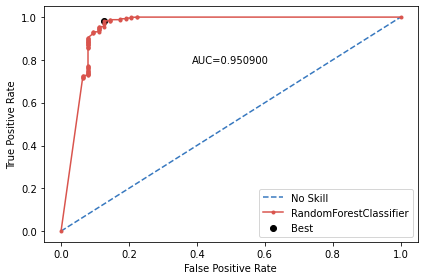

In [ ]:
yhat = model_rfc.predict_proba(X)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
auc = roc_auc_score(y, yhat)
print('AUC=%f' %auc)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RandomForestClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.text(0.5,0.8,'AUC=%f' %round(auc,4) ,horizontalalignment='center',
     verticalalignment='center', fontsize=10, color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.tight_layout()

plt.savefig("ROC rfc toutes localisations", dpi=400)
plt.show()

In [ ]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [ ]:
from numpy import arange
yhat = model_svc.predict_proba(X)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y, to_labels(probs, t)) for t in thresholds]
# get best threshold
ax = argmax(scores)
print('Threshold=%.3f, F1-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.032, F-Score=0.97352


In [ ]:
yhat

array([[9.04988043e-10, 9.99999999e-01],
       [1.04252484e-05, 9.99989575e-01],
       [8.63432087e-14, 1.00000000e+00],
       ...,
       [8.66628905e-08, 9.99999913e-01],
       [1.94293232e-12, 1.00000000e+00],
       [3.60912705e-02, 9.63908730e-01]])

In [ ]:
predictions = np.where(yhat[:,0]>0.90,0,1)

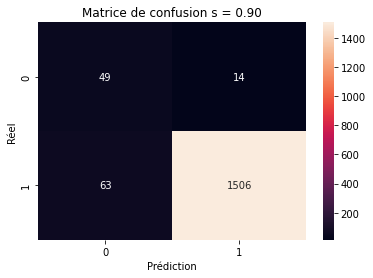

In [ ]:
conf_matrix_SGD_01 = tf.math.confusion_matrix(labels=y, predictions=predictions)
 
ax_sgd_01 = sns.heatmap(conf_matrix_SGD_01, annot = True, fmt='d')
ax_sgd_01.set_title('Matrice de confusion s = 0.90')
ax_sgd_01.set_ylabel('Réel')
ax_sgd_01.set_xlabel('Prédiction')
#plt.savefig("Matrice de confusion svc toutes localisations", dpi=400)
plt.show()


In [ ]:
df['Prob_0_svc'] = yhat[:,0]

In [ ]:
df['Prob_0_svc'].to_csv('prob_svc.csv', index = False)

In [ ]:
df['ClassPredict_svc'] = predictions

In [ ]:
df['ClassPredict_svc'].to_csv('prediction_svc.csv', index = False)

## Vérification des prédictions de l'API sur Streamlit

In [ ]:
indices = "0.7013	0.067	47.0482	0.0512	0.091	0.7353"

In [ ]:
indices = indices.split()
indices_list = []
for elm in indices:
  indices_list.append(float(elm))

In [ ]:
test = np.array(indices_list)
indices = test.reshape(1, -1)

In [ ]:
indices

array([[ 0.7013,  0.067 , 47.0482,  0.0512,  0.091 ,  0.7353]])

In [ ]:
StandardScaler = load('StandardScaler.joblib')

In [ ]:
indices = StandardScaler.transform(indices)

In [ ]:
indices

array([[ 1.86647378, -1.54879792,  0.47705943, -1.45849218, -1.41450624,
        -0.16062192]])

In [ ]:
RFC_model = load('model_rfc_11052022.sav')

In [ ]:
y_pred_prob = RFC_model.predict_proba(indices)
result = np.where(y_pred_prob[:,0]>0.30,0,1)
predictions = result[0]

In [ ]:
y_pred_prob

array([[0.4, 0.6]])

In [ ]:
predictions

0

# Méthode innovantes n° 1 : XBNet

In [ ]:
pip install --upgrade git+https://github.com/tusharsarkar3/XBNet.git

## Importation des données

In [ ]:
df = pad.read_excel('Database_finale.xlsx')
df

,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Class
0,0.4633,0.1076,40.4710,0.0859,0.1338,0.8025,1.0
1,0.4540,0.0997,36.4405,0.0815,0.1233,0.7998,1.0
2,0.4880,0.0803,61.0115,0.0558,0.1058,0.7631,1.0
3,0.4113,0.1118,34.3492,0.0926,0.1467,0.7588,1.0
4,0.6148,0.0940,31.4994,0.0792,0.1329,0.7026,1.0
...,...,...,...,...,...,...,...
1627,0.5041,0.1099,46.2522,0.0845,0.1460,0.7514,1.0
1628,0.4571,0.1253,41.3130,0.0995,0.1825,0.6850,1.0
1629,0.3610,0.1406,30.2030,0.1194,0.2063,0.6746,1.0
1630,0.5300,0.0692,64.1103,0.0470,0.0923,0.7494,1.0


In [ ]:
# Importation des données
X = df.drop("Class", axis = 1)
y = df["Class"]

In [ ]:
X_np = np.array(X)

In [ ]:
sc = StandardScaler()

In [ ]:
X_norm = sc.fit_transform(X_np)

In [ ]:
x_data = X_norm
y_data = y

In [ ]:
le = LabelEncoder()
y_data = np.array(le.fit_transform(y_data))
print(le.classes_)

[0. 1.]


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.3,random_state = 0)

In [ ]:
# Sur-échantillonnage des données d'entraînement
ros = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = ros.fit_resample(X_train, y_train)

## Entrainement du modèle

Enter dimensions of linear layers: 
Enter input dimensions of layer 1: 12
Enter output dimensions of layer 1: 24
Set bias as True or False: True
Enter input dimensions of layer 2: 24
Enter output dimensions of layer 2: 2
Set bias as True or False: True
Enter your last layer 
1. Sigmoid 
2. Softmax 
3. None 
2
Enter dimension for Softmax: 1


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
Percentage training completed:   3%|▎         | 1/30 [00:04<02:08,  4.44s/it]

Training Loss after epoch 1 is 0.5388637182804255 and Accuracy is 79.53667953667954
Validation Loss after epoch 1 is 0.8115759491920471 and Accuracy is 48.775510204081634


Percentage training completed:   7%|▋         | 2/30 [00:09<02:21,  5.07s/it]

Training Loss after epoch 2 is 0.640280776986709 and Accuracy is 66.89189189189189
Validation Loss after epoch 2 is 0.7521266341209412 and Accuracy is 54.89795918367347


Percentage training completed:  10%|█         | 3/30 [00:14<02:09,  4.79s/it]

Training Loss after epoch 3 is 0.6377990323763627 and Accuracy is 67.03667953667954
Validation Loss after epoch 3 is 0.7340993285179138 and Accuracy is 57.142857142857146


Percentage training completed:  13%|█▎        | 4/30 [00:18<02:01,  4.68s/it]

Training Loss after epoch 4 is 0.6516349104734568 and Accuracy is 66.21621621621621
Validation Loss after epoch 4 is 0.7160590887069702 and Accuracy is 59.38775510204081


Percentage training completed:  17%|█▋        | 5/30 [00:23<01:55,  4.63s/it]

Training Loss after epoch 5 is 0.6348568714582004 and Accuracy is 68.0019305019305
Validation Loss after epoch 5 is 0.7002977132797241 and Accuracy is 60.61224489795919


Percentage training completed:  20%|██        | 6/30 [00:27<01:49,  4.57s/it]

Training Loss after epoch 6 is 0.6170022645821938 and Accuracy is 69.64285714285714
Validation Loss after epoch 6 is 0.7031402587890625 and Accuracy is 60.40816326530612


Percentage training completed:  23%|██▎       | 7/30 [00:32<01:44,  4.54s/it]

Training Loss after epoch 7 is 0.6168405950069428 and Accuracy is 69.4015444015444
Validation Loss after epoch 7 is 0.6959237456321716 and Accuracy is 61.02040816326531


Percentage training completed:  27%|██▋       | 8/30 [00:36<01:39,  4.51s/it]

Training Loss after epoch 8 is 0.6059705649430935 and Accuracy is 70.70463320463321
Validation Loss after epoch 8 is 0.6986801624298096 and Accuracy is 61.224489795918366


Percentage training completed:  30%|███       | 9/30 [00:41<01:34,  4.50s/it]

Training Loss after epoch 9 is 0.6122648417949677 and Accuracy is 69.83590733590734
Validation Loss after epoch 9 is 0.6988016366958618 and Accuracy is 61.02040816326531


Percentage training completed:  33%|███▎      | 10/30 [00:45<01:29,  4.48s/it]

Training Loss after epoch 10 is 0.6118911596444937 and Accuracy is 69.98069498069498
Validation Loss after epoch 10 is 0.697891116142273 and Accuracy is 61.02040816326531


Percentage training completed:  37%|███▋      | 11/30 [00:50<01:24,  4.47s/it]

Training Loss after epoch 11 is 0.6146306858612941 and Accuracy is 69.7876447876448
Validation Loss after epoch 11 is 0.6932438611984253 and Accuracy is 61.224489795918366


Percentage training completed:  40%|████      | 12/30 [00:54<01:20,  4.45s/it]

Training Loss after epoch 12 is 0.6052701321931986 and Accuracy is 70.55984555984556
Validation Loss after epoch 12 is 0.6922729015350342 and Accuracy is 61.63265306122449


Percentage training completed:  43%|████▎     | 13/30 [00:59<01:15,  4.45s/it]

Training Loss after epoch 13 is 0.6094750560246981 and Accuracy is 70.17374517374517
Validation Loss after epoch 13 is 0.6962115168571472 and Accuracy is 61.42857142857143


Percentage training completed:  47%|████▋     | 14/30 [01:03<01:11,  4.45s/it]

Training Loss after epoch 14 is 0.6111299631687311 and Accuracy is 70.07722007722008
Validation Loss after epoch 14 is 0.6984227299690247 and Accuracy is 61.224489795918366


Percentage training completed:  50%|█████     | 15/30 [01:07<01:06,  4.46s/it]

Training Loss after epoch 15 is 0.6122311995579646 and Accuracy is 70.07722007722008
Validation Loss after epoch 15 is 0.699225664138794 and Accuracy is 61.224489795918366


Percentage training completed:  53%|█████▎    | 16/30 [01:12<01:02,  4.44s/it]

Training Loss after epoch 16 is 0.6121434528094072 and Accuracy is 70.02895752895753
Validation Loss after epoch 16 is 0.6995419263839722 and Accuracy is 60.816326530612244


Percentage training completed:  57%|█████▋    | 17/30 [01:16<00:57,  4.43s/it]

Training Loss after epoch 17 is 0.6121265938648811 and Accuracy is 70.17374517374517
Validation Loss after epoch 17 is 0.6994588971138 and Accuracy is 61.224489795918366


Percentage training completed:  60%|██████    | 18/30 [01:21<00:53,  4.43s/it]

Training Loss after epoch 18 is 0.6120516284154012 and Accuracy is 70.27027027027027
Validation Loss after epoch 18 is 0.7008135914802551 and Accuracy is 60.816326530612244


Percentage training completed:  63%|██████▎   | 19/30 [01:25<00:48,  4.41s/it]

Training Loss after epoch 19 is 0.6120137508098896 and Accuracy is 69.7876447876448
Validation Loss after epoch 19 is 0.6959444284439087 and Accuracy is 61.63265306122449


Percentage training completed:  67%|██████▋   | 20/30 [01:29<00:43,  4.39s/it]

Training Loss after epoch 20 is 0.6099171576591639 and Accuracy is 70.22200772200772
Validation Loss after epoch 20 is 0.6947243213653564 and Accuracy is 61.63265306122449


Percentage training completed:  70%|███████   | 21/30 [01:34<00:39,  4.40s/it]

Training Loss after epoch 21 is 0.6100739641831472 and Accuracy is 70.17374517374517
Validation Loss after epoch 21 is 0.7003328204154968 and Accuracy is 60.61224489795919


Percentage training completed:  73%|███████▎  | 22/30 [01:38<00:35,  4.40s/it]

Training Loss after epoch 22 is 0.6114691527990195 and Accuracy is 70.12548262548262
Validation Loss after epoch 22 is 0.6967437267303467 and Accuracy is 61.02040816326531


Percentage training completed:  77%|███████▋  | 23/30 [01:43<00:30,  4.39s/it]

Training Loss after epoch 23 is 0.613742108299182 and Accuracy is 70.07722007722008
Validation Loss after epoch 23 is 0.6859748959541321 and Accuracy is 62.6530612244898


Percentage training completed:  80%|████████  | 24/30 [01:47<00:26,  4.40s/it]

Training Loss after epoch 24 is 0.6197544205647249 and Accuracy is 69.83590733590734
Validation Loss after epoch 24 is 0.7000993490219116 and Accuracy is 61.02040816326531


Percentage training completed:  83%|████████▎ | 25/30 [01:53<00:23,  4.77s/it]

Training Loss after epoch 25 is 0.618192992072839 and Accuracy is 69.54633204633204
Validation Loss after epoch 25 is 0.6839392781257629 and Accuracy is 62.44897959183673


Percentage training completed:  87%|████████▋ | 26/30 [01:57<00:18,  4.65s/it]

Training Loss after epoch 26 is 0.6299707729082841 and Accuracy is 68.43629343629344
Validation Loss after epoch 26 is 0.6735432744026184 and Accuracy is 64.08163265306122


Percentage training completed:  90%|█████████ | 27/30 [02:01<00:13,  4.57s/it]

Training Loss after epoch 27 is 0.6067607602247825 and Accuracy is 70.84942084942085
Validation Loss after epoch 27 is 0.6723235249519348 and Accuracy is 63.46938775510204


Percentage training completed:  93%|█████████▎| 28/30 [02:06<00:09,  4.57s/it]

Training Loss after epoch 28 is 0.6285745503810736 and Accuracy is 68.91891891891892
Validation Loss after epoch 28 is 0.6635692715644836 and Accuracy is 64.48979591836735


Percentage training completed:  97%|█████████▋| 29/30 [02:10<00:04,  4.51s/it]

Training Loss after epoch 29 is 0.6003132547323521 and Accuracy is 71.42857142857143
Validation Loss after epoch 29 is 0.6634094715118408 and Accuracy is 64.89795918367346


Percentage training completed: 100%|██████████| 30/30 [02:15<00:00,  4.51s/it]

Training Loss after epoch 30 is 0.6421246654712237 and Accuracy is 67.32625482625483
Validation Loss after epoch 30 is 0.6412151455879211 and Accuracy is 66.93877551020408
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      1036
           1       0.65      0.73      0.69      1036

    accuracy                           0.67      2072
   macro avg       0.68      0.67      0.67      2072
weighted avg       0.68      0.67      0.67      2072

              precision    recall  f1-score   support

           0       0.14      0.69      0.23        35
           1       0.97      0.67      0.79       455

    accuracy                           0.67       490
   macro avg       0.55      0.68      0.51       490
weighted avg       0.91      0.67      0.75       490

Validation Loss after epoch 30 is 0.6412151455879211 and Accuracy is 66.93877551020408


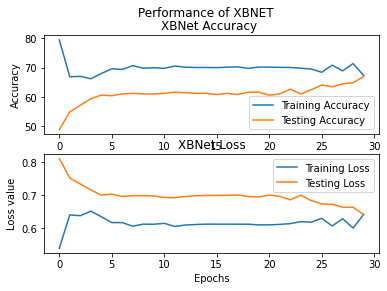

In [ ]:
model = XBNETClassifier(X_train,y_train,2)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

m,acc, lo, val_ac, val_lo = run_XBNET(X_train,X_test,y_train,y_test,model,criterion,optimizer,16,30)
results = predict(m,x_data)

In [ ]:
X_tensor = torch.from_numpy(X_norm)

## Prédiction

In [ ]:
outputs = model(X_tensor.float())

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [ ]:
proba = outputs[:,:].detach().numpy()

In [ ]:
proba

array([[1.1325469e-03, 9.9886751e-01],
       [9.9967885e-01, 3.2112902e-04],
       [6.5952368e-17, 1.0000000e+00],
       ...,
       [6.9224357e-32, 1.0000000e+00],
       [1.2520103e-15, 1.0000000e+00],
       [1.5771693e-04, 9.9984229e-01]], dtype=float32)

In [ ]:
predictions = np.where(proba[:,0]>0.50,0,1)

In [ ]:
predictions[:300]

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
df['ClassPredict'] = predictions

In [ ]:
df['ClassPredict'].to_csv('prediction.csv', index = False)

In [ ]:
proba

array([[1.1325469e-03, 9.9886751e-01],
       [9.9967885e-01, 3.2112902e-04],
       [6.5952368e-17, 1.0000000e+00],
       ...,
       [6.9224357e-32, 1.0000000e+00],
       [1.2520103e-15, 1.0000000e+00],
       [1.5771693e-04, 9.9984229e-01]], dtype=float32)

Best Threshold=0.999492, G-Mean=0.693


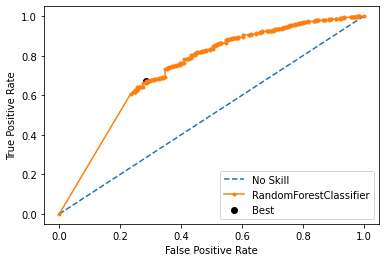

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y, proba)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RandomForestClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
auc = roc_auc_score(y, proba)
print(auc)

0.7366206696443436


In [ ]:
dump(model, "XBNet.joblib")

['XBNet.joblib']

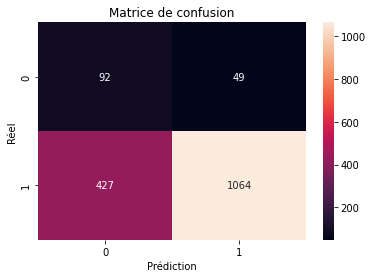

In [ ]:
conf_matrix = tf.math.confusion_matrix(labels=y_data, predictions=predictions)
 
ax_sgd_01 = sns.heatmap(conf_matrix, annot = True, fmt='d')
ax_sgd_01.set_title('Matrice de confusion')
ax_sgd_01.set_ylabel('Réel')
ax_sgd_01.set_xlabel('Prédiction')
plt.show()

In [ ]:
df['ClassPredict'] = predictions

In [ ]:
df['ClassPredict'].to_csv('prediction.csv', index = False)

# Méthode innovantes n° 2 : LibAUC

In [ ]:
!pip install libauc==1.1.8

### **Reproducibility**

In [ ]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### **Loading and Preprocessing Dataset**


In [ ]:
df = pad.read_excel('Database_LibAUC_0.xlsx')
df.dropna(axis = 0, how ='any')

,Feature_01,Feature_02,Feature_03,Feature_04,Feature_05,Feature_06,Class
0,0.4633,0.1076,40.4710,0.0859,0.1338,0.8025,0.0
1,0.4540,0.0997,36.4405,0.0815,0.1233,0.7998,0.0
2,0.4880,0.0803,61.0115,0.0558,0.1058,0.7631,0.0
3,0.4113,0.1118,34.3492,0.0926,0.1467,0.7588,0.0
4,0.6148,0.0940,31.4994,0.0792,0.1329,0.7026,0.0
...,...,...,...,...,...,...,...
1627,0.5041,0.1099,46.2522,0.0845,0.1460,0.7514,0.0
1628,0.4571,0.1253,41.3130,0.0995,0.1825,0.6850,0.0
1629,0.3610,0.1406,30.2030,0.1194,0.2063,0.6746,0.0
1630,0.5300,0.0692,64.1103,0.0470,0.0923,0.7494,0.0


In [ ]:
raw_df = df

In [ ]:
# Reference: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

cleaned_df = raw_df.copy()

# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

# Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.
# Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Examples:
    Total: 1632
    Positive: 141 (8.64% of total)

Training labels shape: (1044,)
Validation labels shape: (261,)
Test labels shape: (327,)
Training features shape: (1044, 6)
Validation features shape: (261, 6)
Test features shape: (327, 6)


### **Paramaters**

In [ ]:
# random seed
SEED = 123

# you can tune these parameters 
BATCH_SIZE = 8
lr = 0.3
gamma = 500
weight_decay = 1e-5
margin = 1.0

# compute imbalance ratio based training set 
imratio = train_labels.sum()/train_labels.shape[0]

### **Loading Dataset**

In [ ]:
class CreditFraudDataset(Dataset):
    def __init__(self, data, target):
        self.data = data.astype(np.float32) # numpy array
        self.targets = target.astype(np.float32) # numpy array

    def __getitem__(self, index):
        data = self.data[index]
        target = self.targets[index]
        return data, target

    def __len__(self):
        return self.data.shape[0]

trainDataset = CreditFraudDataset(train_features, train_labels)
valDataset = CreditFraudDataset(val_features, val_labels)
testDataset = CreditFraudDataset(test_features, test_labels)

trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
valloader = torch.utils.data.DataLoader(valDataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1,  pin_memory=False)
testloader = torch.utils.data.DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1,  pin_memory=False)

### **Defining a multi-layer perceptron (Neural Network)**

In [ ]:
from torch import nn
import torch.nn.functional as F

# you can extend this model to multi-layer perceptron
class MLP(torch.nn.Module):
    def __init__(self, input_dim=6, nn_dim=200, num_classes=1):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, nn_dim) #  increase number of layers here
        self.dropout = nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(nn_dim, 400) #  increase number of layers here
        self.dropout = nn.Dropout(0.5)
        self.fc3 = torch.nn.Linear(400, 800) #  increase number of layers here
        self.dropout = nn.Dropout(0.5)
        self.fc4 = torch.nn.Linear(800, num_classes)
    def forward(self, x):
        x1 = self.dropout(F.relu(self.fc1(x)))
        x2 = self.dropout(F.relu(self.fc2(x1)))
        x3 = self.dropout(F.relu(self.fc3(x2)))        
        return torch.sigmoid(self.fc4(x3))

### **Creating models & AUC Optimizer**

In [ ]:
set_all_seeds(SEED)
model = MLP(input_dim=6, num_classes=1) # num_classs=1 since we output 1 or 0 here
model = model.cuda()

Loss = AUCMLoss(imratio=imratio)
optimizer = PESG(model, 
                 a=Loss.a, 
                 b=Loss.b, 
                 alpha=Loss.alpha,  
                 lr=lr, 
                 gamma=gamma, 
                 margin=margin, 
                 weight_decay=weight_decay)

### **Training**

In [1]:
def evaluate(data, model):
     model.eval()
     pred = []
     true = [] 
     for j, data in enumerate(data):
         data, targets = data
         data = data.cuda()
         y_pred = model(data)
         pred.append(y_pred.cpu().detach().numpy())
         true.append(targets.numpy())
     true = np.concatenate(true)
     pred = np.concatenate(pred)
     val_auc =  roc_auc_score(true, pred) 
     return val_auc

In [ ]:
print ('Start Training')
print ('-'*30)
for epoch in range(100):
    
     if epoch == 50 or epoch==75:
         # decrease learning rate by 10x & update regularizer
         optimizer.update_regularizer(decay_factor=10)
   
     train_pred = []
     train_true = []
     model.train()    
     for data, targets in trainloader:
         data, targets  = data.cuda(), targets.cuda()
         y_pred = model(data)
         loss = Loss(y_pred, targets)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         train_pred.append(y_pred.cpu().detach().numpy())
         train_true.append(targets.cpu().detach().numpy())

     train_true = np.concatenate(train_true)
     train_pred = np.concatenate(train_pred)
     train_auc = roc_auc_score(train_true, train_pred) 

     val_auc = evaluate(valloader, model)
     test_auc = evaluate(testloader, model)

     # print results
     print("epoch: {}, train_loss: {:4f}, train_auc:{:4f}, val_auc:{:4f}, test_auc:{:4f},  lr:{:4f}".format(epoch, loss.item(), train_auc, val_auc, test_auc, optimizer.lr ))

Start Training
------------------------------
epoch: 0, train_loss: 0.112865, train_auc:0.646928, val_auc:0.809750, test_auc:0.633681,  lr:0.300000
epoch: 1, train_loss: 0.142306, train_auc:0.698746, val_auc:0.824628, test_auc:0.671535,  lr:0.300000
epoch: 2, train_loss: 0.161619, train_auc:0.714468, val_auc:0.830801, test_auc:0.687630,  lr:0.300000
epoch: 3, train_loss: -0.054882, train_auc:0.734552, val_auc:0.832700, test_auc:0.704918,  lr:0.300000
epoch: 4, train_loss: 0.134854, train_auc:0.751850, val_auc:0.826686, test_auc:0.705663,  lr:0.300000
epoch: 5, train_loss: 0.116377, train_auc:0.755617, val_auc:0.827477, test_auc:0.707004,  lr:0.300000
epoch: 6, train_loss: 0.141628, train_auc:0.763633, val_auc:0.832067, test_auc:0.715052,  lr:0.300000
epoch: 7, train_loss: 0.193329, train_auc:0.769730, val_auc:0.830643, test_auc:0.716095,  lr:0.300000
epoch: 8, train_loss: 0.114239, train_auc:0.737600, val_auc:0.832067, test_auc:0.710730,  lr:0.300000
epoch: 9, train_loss: 0.120153, tra

## Prediction

In [ ]:
X = df.drop('Class', axis=1)
X_norm = scaler.transform(X)
X_tensor = torch.from_numpy(X_norm)
X_tensor = X_tensor.cuda()
y = df['Class']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
outputs = model(X_tensor.float())

In [ ]:
proba = outputs.cpu()[:,:].detach().numpy()

In [ ]:
proba

array([[0.32251382],
       [0.46418366],
       [0.26707017],
       ...,
       [0.03778607],
       [0.38745627],
       [0.6901977 ]], dtype=float32)

In [ ]:
predictions = np.where(proba>0.20,0,1)

In [ ]:
predictions

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

Best Threshold=0.519712, G-Mean=0.736


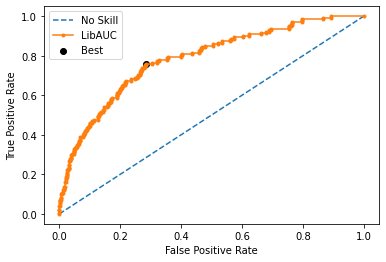

In [ ]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y, proba)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LibAUC')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
auc = roc_auc_score(y, proba)
print(auc)

In [ ]:
dump(model, "LibAUC.joblib")

['LibAUC.joblib']

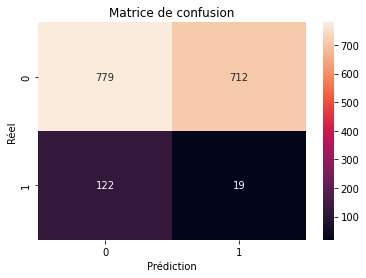

In [ ]:
conf_matrix = tf.math.confusion_matrix(labels=y, predictions=predictions)
 
ax_sgd_01 = sns.heatmap(conf_matrix, annot = True, fmt='d')
ax_sgd_01.set_title('Matrice de confusion')
ax_sgd_01.set_ylabel('Réel')
ax_sgd_01.set_xlabel('Prédiction')
plt.show()

In [ ]:
df['ClassPredict'] = predictions

In [ ]:
df['ClassPredict'].to_csv('prediction.csv', index = False)